In [15]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import os
import PIL
import numpy as np
from matplotlib import pyplot

In [35]:
class BaseNeuralNetwork:
    def __init__(self, name, input_shape):
        self.name = name
        self.model = None
        self.random_normal = RandomNormal(stddev=.02)
        self.input_layer = Input(shape=input_shape)
        self.output_layer = None

    def model_summary(self):
        if self.model:
            print(self.model.summary())
        else:
            print("{} is not built yet".format(self.name))
            
    #candidate for more template treatment
        #conv transpose or not
        #leaky relu, normal relu, or none
        #etc
    def create_conv_block(self, input_layer, output_space, kernal_size, instance_norm=True, relu='leaky', strides=(2, 2), transpose=False):
        if transpose:
            conv = Conv2DTranspose(output_space, 
                                   kernal_size, 
                                   strides=strides, 
                                   padding='same', 
                                   kernel_initializer=self.random_normal)(input_layer)
        else:
            conv = Conv2D(output_space, 
                          kernal_size, 
                          strides=strides, 
                          padding='same', 
                          kernel_initializer=self.random_normal)(input_layer)
            
        if instance_norm: conv = InstanceNormalization(axis=-1)(conv) 
        if relu == 'leaky': conv = LeakyReLU(alpha=.2)(conv)
        if relu == 'normal': conv = Activation('relu')(conv)
        return conv
        
        
class Discriminator(BaseNeuralNetwork):
    def __init__(self, name, input_shape):
        super().__init__(name, input_shape)
        
    def paper_build(self):    
        c = self.create_conv_block(self.input_layer, 64, (4, 4), instance_norm=False)
        c = self.create_conv_block(c, 128, (4, 4))
        c = self.create_conv_block(c, 256, (4, 4))
        c = self.create_conv_block(c, 512, (4, 4))
        c = self.create_conv_block(c, 512, (4, 4), strides=(1, 1))
        out = self.create_conv_block(c, 1, (4, 4), instance_norm=False, relu=None, strides=(1, 1))
        self.output_layer = out
    
    def compile_model(self):
        if self.output_layer is not None:
            self.model = Model(self.input_layer, self.output_layer)
            self.model.name = self.name
            self.model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
        else:
            print('No output layers provided for {}'.format(self.name))
            
class Generator(BaseNeuralNetwork):
    def __init__(self, name, input_shape):
        super().__init__(name, input_shape)
        
    def create_resnet_block(self, input_layer, output_space):
        #first layer
        res = self.create_conv_block(input_layer, output_space, (3, 3), relu='normal', strides=(1, 1))
        # second convolutional layer
        res = self.create_conv_block(res, output_space, (3, 3), relu=None, strides=(1, 1))
        # concatenate merge channel-wise with input layer
        res = Concatenate()([res, input_layer])
        return res
    
    def paper_build(self):
        c = self.create_conv_block(self.input_layer, 64, (7, 7), relu='normal', strides=(1, 1))
        c = self.create_conv_block(c, 128, (3, 3), relu='normal')
        c = self.create_conv_block(c, 256, (3, 3), relu='normal')
        for _ in range(9):
            c = self.create_resnet_block(c, 256)
        c = self.create_conv_block(c, 128, (3, 3), relu='normal', transpose=True)
        c = self.create_conv_block(c, 64, (3, 3), relu='normal', transpose=True)
        c = self.create_conv_block(c, 3, (7, 7), relu=None, strides=(1, 1))
        out = Activation('tanh')(c)
        self.output_layer = out
    
    def compile_model(self):
        if self.output_layer is not None:
            self.model = Model(self.input_layer, self.output_layer)
            self.model.name = self.name
        else:
            print('No output layers provided for {}'.format(self.name))
            
    def generate_fake_samples(self, dataset, patch_shape):
        X = self.model.predict(dataset)
        #fake images have label of zero
        y = np.zeros((len(X), patch_shape, patch_shape, 1))
        return X, y
    
    
class Composite():
    def __init__(self, name, g1, d1, g2, input_shape):
        g_model_1 = g1.model
        d_model = d1.model
        g_model_2 = g2.model
        
        #We are only training the first generator
        g_model_1.trainable = True
        d_model.trainable = False
        g_model_2.trainable = False
        
        #discriminator element
        #generator 1 creates an image for domain 1 and discriminator 1 try to see if it was real or fake
        input_gen = Input(shape=input_shape)
        gen1_out = g_model_1(input_gen)
        output_d = d_model(gen1_out)
        
        #identity element
        #generator 1 receives a real image from domain 1 and trys not to change it
        input_id = Input(shape=input_shape)
        output_id = g_model_1(input_id)
        
        #forward cycle
        #generator 2 receives an image from generator 1 and tries to change it back to domain 2
        output_f = g_model_2(gen1_out)
        
        #backward cycle
        #generator 2 receives real image from domain 1 and gives it to generator 1 who tries to change it back to domain 1
        gen2_out = g_model_2(input_id)
        output_b = g_model_1(gen2_out)
        
        self.model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    def compile_model(self):
        self.model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=Adam(lr=.0002, beta_1=.5))
        
    def model_summary(self):
        if self.model:
            print(self.model.summary())
        else:
            print("{} is not built yet".format(self.name))

In [36]:
image_shape = (256, 256, 3)
d1 = Discriminator('Impr-Discriminator', image_shape)
g1 = Generator('Impr-Generator', image_shape)
d2 = Discriminator('Photo-Discriminator', image_shape)
g2 = Generator('Photo-Generator', image_shape)

In [37]:
d1.paper_build()
g1.paper_build()
d2.paper_build()
g2.paper_build()

In [38]:
d1.compile_model()
g1.compile_model()
d2.compile_model()
g2.compile_model()

In [39]:
i2p = Composite('Impr to Photo', g1, d1, g2, image_shape)
p2i = Composite('Photo to Impr', g2, d2, g1, image_shape)

In [46]:
i2p.compile_model()
p2i.compile_model()

In [7]:
image_loader = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=15,
                                  width_shift_range=.2,
                                  height_shift_range=.1,
                                  zoom_range=.2,
                                  horizontal_flip=True,
                                 )

In [10]:
def load_samples(path):
    all_files = os.listdir(path)
    imgs = np.zeros((1300, 256, 256, 3))
    for i in range(1300):
    #for i, file in enumerate(all_files):
        file = all_files[i]
        print(i, end='\r')
        image = np.array(load_img(path+'/'+ file, target_size=(256, 256)))
        image = (image - 127.5) / 127.5
        imgs[i] = image
        #imgs.append(image)
        del image
        
    print('\nend')
    return imgs

In [11]:
impr_imgs = load_samples('monet-paintings')

1299
end


In [12]:
photo_imgs = load_samples('landscape-pictures')

1299
end


In [13]:
print(photo_imgs.shape)
print(photo_imgs[0][0][0])
print(impr_imgs.shape)
print(impr_imgs[0][0][0])

(1300, 256, 256, 3)
[-0.98431373 -0.79607843 -0.76470588]
(1300, 256, 256, 3)
[0.67058824 0.75686275 0.91372549]


In [14]:
np.save('monet-paintings.npy', impr_imgs)
np.save('landscape-photos.npy', photo_imgs)

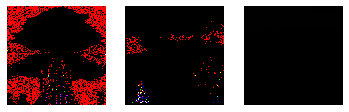

In [17]:
for i in range(3):
    pyplot.subplot(2, 3, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(photo_imgs[i].astype('uint8'))

In [40]:
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [41]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = g_model.generate_fake_samples(X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [42]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [43]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.model.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [51]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 10, 10
    # determine the output square shape of the discriminator
    n_patch = d_model_A.model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = g_model_BtoA.generate_fake_samples(X_realB, n_patch)
        X_fakeB, y_fakeB = g_model_AtoB.generate_fake_samples(X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.model.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.model.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.model.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.model.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.model.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.model.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (int(bat_per_epo / 5)) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [52]:
train(d1, d2, g1, g2, i2p, p2i, (impr_imgs, photo_imgs))

ResourceExhaustedError:  OOM when allocating tensor with shape[10,64,64,1792] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Photo-Generator_8/concatenate_33/concat (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_58455]

Function call stack:
keras_scratch_graph


In [50]:
summarize_performance(0, g2, photo_imgs, 'BtoA')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
